In [284]:
import sys
import os
import datetime
import pandas as pd
import pandas_ta as ta
import numpy as np
sys.path.append(r"C:\Users\DeGenOne\degen-money-backtest")
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 5000000)

In [281]:
from backtest.data.data import DataProducer, get_all_expiry_info, fetch_options_data_and_resample, get_expiry_dates, get_expiry_comp_dict
from backtest.strategy.strategy import Strategy
from backtest.utils import utils
from backtest.opt_backtest.opt_backtest import OptBacktest


In [375]:
instrument = "BANKNIFTY"
start_date = "2019-01-01"
end_date = "2019-12-31"
timeframe = "1min"
data = DataProducer(instrument, start_date, end_date, timeframe)

In [376]:
df = data.resampled_historical_df
df["day"] = df["date"].dt.date
df = df[df["date"].dt.year == 2019]
expiry_dates = data.bnf_expiry_dates_list
expiry_comp_dict = data.bnf_expiry_comp_dict
filtered_expiry = []
for x in expiry_dates:
    if x.year == 2019:
        filtered_expiry.append(x)
filtered_df = df[df['date'].dt.date.isin(filtered_expiry)]
filtered_df.reset_index(drop=True, inplace=True)
filtered_df = filtered_df.groupby("day")
ce_options_data = []
pe_options_data = []

track_time = utils.str_to_time_obj("9:20")

for day, day_df in filtered_df:
    close = day_df[day_df["date"].dt.time == track_time]["close"]
    atm = int(round(close, -2))
    ce_otm1 = atm + 100
    pe_otm1 = atm - 100
    expiry_comp = expiry_comp_dict[day]
    ce_opt_symbol = f"BANKNIFTY{expiry_comp}{ce_otm1}CE"
    pe_opt_symbol = f"BANKNIFTY{expiry_comp}{pe_otm1}PE"
    ce_symbol_data = fetch_options_data_and_resample(ce_opt_symbol, day, day, "15min")
    ce_symbol_data = ce_symbol_data.rename(columns={f"{ce_opt_symbol}_close":"close",
                                                 f"{ce_opt_symbol}_open":"open",
                                                  f"{ce_opt_symbol}_high": "high",
                                                    f"{ce_opt_symbol}_low":"low",
                                                    f"{ce_opt_symbol}_volume":"volume"})
    pe_symbol_data = fetch_options_data_and_resample(pe_opt_symbol, day, day, "15min")
    pe_symbol_data = ce_symbol_data.rename(columns={f"{pe_opt_symbol}_close":"close",
                                                 f"{pe_opt_symbol}_open":"open",
                                                  f"{pe_opt_symbol}_high": "high",
                                                    f"{pe_opt_symbol}_low":"low",
                                                    f"{pe_opt_symbol}_volume":"volume"})
    ce_options_data.append(ce_symbol_data)
    pe_options_data.append(pe_symbol_data)
ce_options_df = pd.concat(ce_options_data, ignore_index=True)
pe_options_df = pd.concat(ce_options_data, ignore_index=True)

In [377]:
# display(ce_options_df)
ce_options_df["date"] = pd.to_datetime(ce_options_df["date"])
ce_options_df["rsi"] = ta.rsi(ce_options_df["close"], window=20)
ce_options_df.dropna(inplace=True)
ce_options_df.reset_index(drop=True, inplace=True)
ce_options_df["time"] = ce_options_df["date"].dt.time
ce_options_df.set_index("date", inplace=True)

# display(ce_options_df)
# ce_options_df[ce_options_df["date"].dt.date == datetime.datetime()]

In [378]:
ce_options_df

,open,high,low,close,volume,rsi,time
date,,,,,,,
2019-01-03 12:45:00,11.95,13.90,8.10,9.25,1922600.0,27.977347,12:45:00
2019-01-03 13:00:00,9.15,16.80,9.15,12.50,2589180.0,32.260723,13:00:00
2019-01-03 13:15:00,12.60,16.05,9.05,9.40,2322020.0,30.403340,13:15:00
2019-01-03 13:30:00,9.15,9.15,1.90,2.60,5265620.0,26.763354,13:30:00
2019-01-03 13:45:00,2.60,4.40,1.70,3.30,2806220.0,27.722654,13:45:00
2019-01-03 14:00:00,3.25,4.80,1.15,1.40,3044240.0,26.700343,14:00:00
2019-01-03 14:15:00,1.40,1.85,0.75,0.95,2919500.0,26.451547,14:15:00
2019-01-03 14:30:00,0.90,1.60,0.45,0.50,2826260.0,26.188747,14:30:00
2019-01-03 14:45:00,0.45,0.50,0.15,0.25,2920320.0,26.033998,14:45:00


In [379]:
ce_options_df["change"] = ce_options_df["close"].shift(-1) - ce_options_df["close"]
ce_options_df["rsi"] = ce_options_df["rsi"].apply(lambda x: np.where(x < 45, -1, x))
ce_options_df["rsi"] = ce_options_df["rsi"].apply(lambda x: np.where(x > 55, 1, x))
ce_options_df["rsi"] = ce_options_df["rsi"].apply(lambda x: np.where(abs(x) == 1, x, 0))

In [380]:
pp = ce_options_df[["rsi", "change", "time"]]

In [381]:
pp = pp[pp["time"] <= datetime.time(15, 0)]

In [392]:
pp[pp["rsi"] == 1]

,rsi,change,time
date,,,
2019-01-10 09:15:00,1.0,-6.65,09:15:00
2019-01-10 09:30:00,1.0,1.75,09:30:00
2019-01-10 09:45:00,1.0,-0.15,09:45:00
2019-01-10 10:00:00,1.0,5.50,10:00:00
2019-01-10 10:15:00,1.0,-6.30,10:15:00
2019-01-10 10:30:00,1.0,-1.00,10:30:00
2019-01-17 09:15:00,1.0,0.55,09:15:00
2019-01-17 09:30:00,1.0,0.00,09:30:00
2019-01-17 09:45:00,1.0,-0.75,09:45:00


In [385]:
pp.groupby("rsi")["change"].sum()

rsi
-1.0   -588.80
 0.0   -646.85
 1.0    145.00
Name: change, dtype: float64

In [386]:
pp = pp[pp["rsi"] == 1]

<Axes: xlabel='time'>

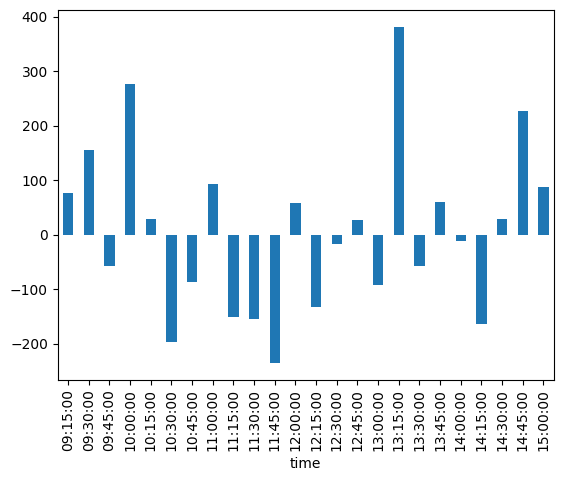

In [391]:
pp.groupby("time").sum()["change"].plot(kind="bar")